#### Conjunto de Datos (Retail)

Lanzamiento: Ventas mensuales anticipadas para minoristas y servicios alimenticios

Unidades: Millones de dólares

Frecuencia: Mensual

El valor del mes más reciente es una estimación anticipada que se basa en datos de una submuestra de empresas de la Encuesta Mensual de Comercio Minorista más grande. La estimación anticipada será reemplazada en los meses siguientes por estimaciones revisadas derivadas de la Encuesta Mensual de Comercio Minorista más grande. La serie asociada de la Encuesta mensual de comercio minorista está disponible en https://fred.stlouisfed.org/series/MRTSSM448USN

Se puede encontrar información sobre la encuesta de ventas minoristas mensual anticipada en el sitio web del censo en https://www.census.gov/retail/marts/about_the_surveys.html


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
generation = "MOD4GEN13"

In [ ]:
df = pd.read_csv(f'/content/drive/MyDrive/{generation}/4.4 Modelado Secuencial/datasets/RSCCASN.csv', index_col='DATE', parse_dates=True)
#Hace un parseo de fechas por defecto

In [ ]:
df.columns = ['Sales']

In [ ]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


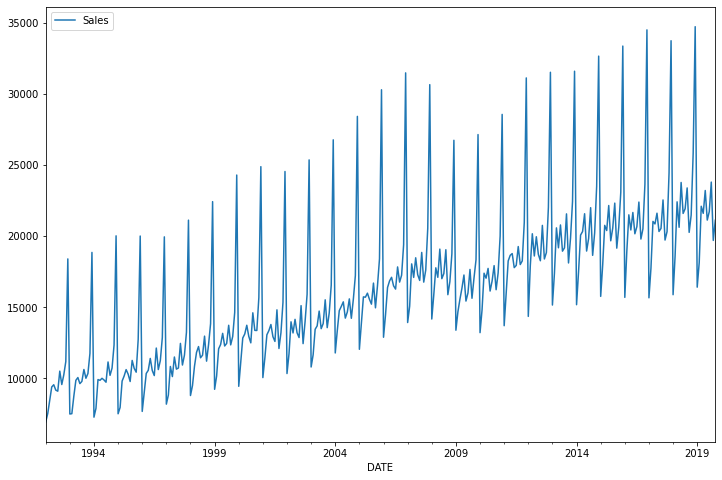

In [ ]:
df.plot(figsize=(12,8));

#### Train Test Split

In [ ]:
#Previo a la particion se recomienda hacer un preprocesamiento de series de tiempo
len(df) #Validamos la longitud

334

Los datos tienen frecuencia mensual, por lo que se propone pronosticar 1 año en el futuro, es decir, 12 meses adelante.

In [ ]:
len(df)-36 #Queremos 36 meses de validacion

298

In [ ]:
val_size = 36

In [ ]:
val_ind = len(df) - val_size

In [ ]:
train = df.iloc[:val_ind]
val = df.iloc[val_ind:]

In [ ]:
train.tail()

,Sales
DATE,
2016-06-01,20160
2016-07-01,20667
2016-08-01,22388
2016-09-01,19790
2016-10-01,20500


In [ ]:
val.head()

,Sales
DATE,
2016-11-01,23644
2016-12-01,34482
2017-01-01,15663
2017-02-01,17745
2017-03-01,21028


#### Preprocesamiento

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(train)

MinMaxScaler()

In [ ]:
Xs_train = scaler.transform(train)
Xs_val = scaler.transform(val)

In [ ]:
true_val = scaler.inverse_transform(Xs_val) #Mantenemos el escalado original

#### Time Series Generator

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# Se crearán ventanas de tiempo de 12 meses para luego predecir el siguiente mes
length = 12
batch_size = 1
n_features = 1

In [ ]:
generator = TimeseriesGenerator(Xs_train, Xs_train, length=length, batch_size=batch_size)
validation_generator = TimeseriesGenerator(Xs_val, Xs_val, length=length, batch_size=batch_size)

In [ ]:
X, y = generator[0]

In [ ]:
print(f'Dada la matriz X: {X.flatten()} \n')
print(f'Predecir esta y: {y}')

Dada la matriz X: [0.         0.02219109 0.05820426 0.09327072 0.09921612 0.08497747
 0.08198584 0.13538077 0.09978415 0.12557276 0.16090431 0.43386223] 

Predecir esta y: [[0.02135797]]


In [ ]:
Xs_train[:13]

array([[0.        ],
       [0.02219109],
       [0.05820426],
       [0.09327072],
       [0.09921612],
       [0.08497747],
       [0.08198584],
       [0.13538077],
       [0.09978415],
       [0.12557276],
       [0.16090431],
       [0.43386223],
       [0.02135797]])

### Modelación

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

#### RNN

In [ ]:
from tensorflow.keras.layers import SimpleRNN

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(100, activation='relu', input_shape=(length,n_features)))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')

In [ ]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 100)               10200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 10,301
Trainable params: 10,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_rnn.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
286/286 [==============================] - 6s 11ms/step - loss: 0.0246 - val_loss: 0.0185
Epoch 2/20
286/286 [==============================] - 3s 10ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 3/20
286/286 [==============================] - 3s 10ms/step - loss: 0.0011 - val_loss: 0.0044
Epoch 4/20
286/286 [==============================] - 3s 10ms/step - loss: 0.0020 - val_loss: 0.0052
Epoch 5/20
286/286 [==============================] - 3s 10ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/20
286/286 [==============================] - 3s 10ms/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/20
286/286 [==============================] - 4s 14ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 8/20
286/286 [==============================] - 4s 12ms/step - loss: 8.4929e-04 - val_loss: 0.0039
Epoch 9/20
286/286 [==============================] - 4s 15ms/step - loss: 0.0010 - val_loss: 0.0072
CPU times: user 39.1 s, sys: 4.41 s, total: 43.5 s
Wall time: 32.7 s


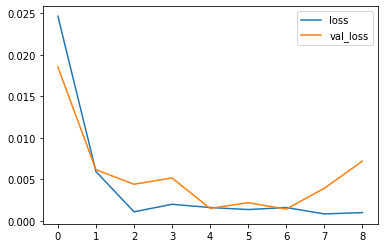

In [ ]:
losses = pd.DataFrame(model_rnn.history.history)
losses.plot();

In [ ]:
val_predictions = []

first_eval_batch = Xs_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(val)):
    
    # Obtiene la primera predicción por delante ([0] es para tomar solo el elemento en lugar del arreglo)
    current_pred = model_rnn.predict(current_batch)[0]
    
    # Almacena predicción
    val_predictions.append(current_pred) 
    
    # Actualiza el lote para incluir la predicción y eliminar el primer valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

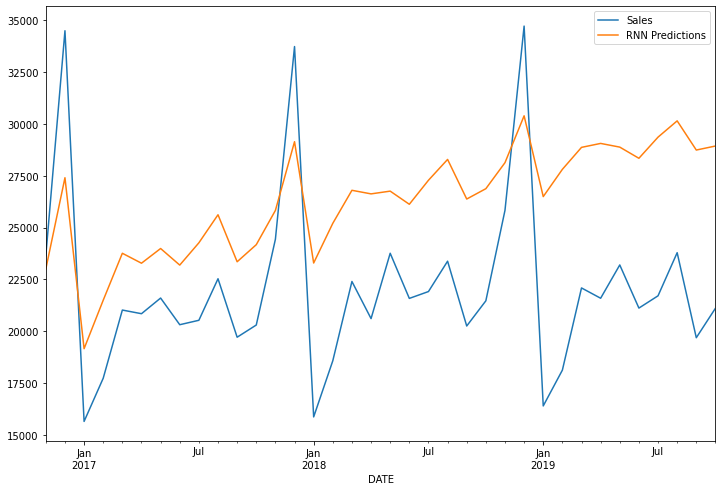

In [ ]:
true_predictions = scaler.inverse_transform(val_predictions)
val['RNN Predictions'] = true_predictions
val.plot(figsize=(12,8));

In [ ]:
print(f"MSE: {mean_squared_error(y_true=true_val, y_pred=true_predictions)}")
print(f"MAE: {mean_absolute_error(y_true=true_val, y_pred=true_predictions)}")
print(f"R2: {r2_score(y_true=true_val, y_pred=true_predictions)}")

MSE: 31340649.34468993
MAE: 5104.847320588098
R2: -0.6861208866206308


#### LSTM

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu', input_shape=(length,n_features)))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_lstm.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
286/286 [==============================] - 8s 23ms/step - loss: 0.0266 - val_loss: 0.0360
Epoch 2/20
286/286 [==============================] - 7s 25ms/step - loss: 0.0200 - val_loss: 0.0343
Epoch 3/20
286/286 [==============================] - 6s 22ms/step - loss: 0.0187 - val_loss: 0.0147
Epoch 4/20
286/286 [==============================] - 7s 25ms/step - loss: 0.0094 - val_loss: 0.0024
Epoch 5/20
286/286 [==============================] - 6s 23ms/step - loss: 0.0043 - val_loss: 0.0097
Epoch 6/20
286/286 [==============================] - 6s 22ms/step - loss: 0.0022 - val_loss: 0.0036
CPU times: user 55.7 s, sys: 7.09 s, total: 1min 2s
Wall time: 41.7 s


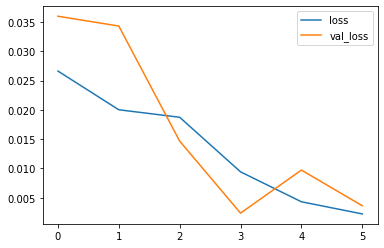

In [ ]:
losses = pd.DataFrame(model_lstm.history.history)
losses.plot();

In [ ]:
val_predictions = []

first_eval_batch = Xs_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(val)):
    
    # Obtiene la primera predicción por delante ([0] es para tomar solo el elemento en lugar del arreglo)
    current_pred = model_lstm.predict(current_batch)[0]
    
    # Almacena predicción
    val_predictions.append(current_pred) 
    
    # Actualiza el lote para incluir la predicción y eliminar el primer valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

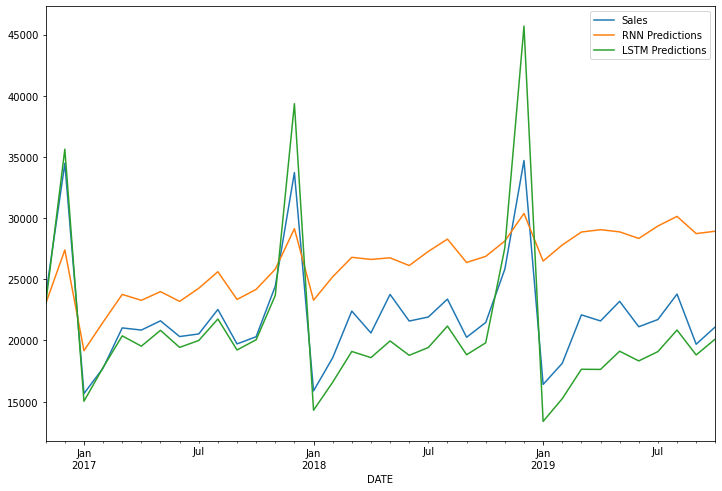

In [ ]:
true_predictions = scaler.inverse_transform(val_predictions)
val['LSTM Predictions'] = true_predictions
val.plot(figsize=(12,8));

In [ ]:
print(f"MSE: {mean_squared_error(y_true=true_val, y_pred=true_predictions)}")
print(f"MAE: {mean_absolute_error(y_true=true_val, y_pred=true_predictions)}")
print(f"R2: {r2_score(y_true=true_val, y_pred=true_predictions)}")

MSE: 8811205.393903235
MAE: 2200.0908989314403
R2: 0.5259588501958783


#### GRU

In [ ]:
from tensorflow.keras.layers import GRU

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(100, activation='relu', input_shape=(length,n_features)))
model_gru.add(Dense(1))

model_gru.compile(optimizer='adam', loss='mse')

In [ ]:
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 100)               30900     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 31,001
Trainable params: 31,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
model_gru.fit_generator(generator, epochs=20, validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
286/286 [==============================] - 11s 34ms/step - loss: 0.0277 - val_loss: 0.0287
Epoch 2/20
286/286 [==============================] - 8s 28ms/step - loss: 0.0215 - val_loss: 0.0271
Epoch 3/20
286/286 [==============================] - 8s 28ms/step - loss: 0.0196 - val_loss: 0.0232
Epoch 4/20
286/286 [==============================] - 8s 28ms/step - loss: 0.0158 - val_loss: 0.0118
Epoch 5/20
286/286 [==============================] - 8s 28ms/step - loss: 0.0073 - val_loss: 0.0024
Epoch 6/20
286/286 [==============================] - 8s 28ms/step - loss: 0.0027 - val_loss: 0.0024
Epoch 7/20
286/286 [==============================] - 8s 28ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/20
286/286 [==============================] - 8s 29ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 9/20
286/286 [==============================] - 8s 28ms/step - loss: 0.0012 - val_loss: 0.0017
CPU times: user 1min 43s, sys: 13.7 s, total: 1min 56s
Wall time: 1min 15s


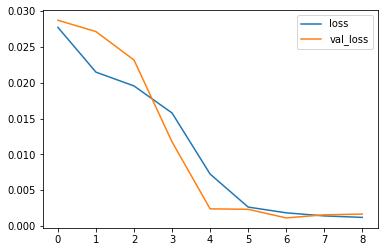

In [ ]:
losses = pd.DataFrame(model_gru.history.history)
losses.plot();

In [ ]:
val_predictions = []

first_eval_batch = Xs_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(val)):
    
    # Obtiene la primera predicción por delante ([0] es para tomar solo el elemento en lugar del arreglo)
    current_pred = model_gru.predict(current_batch)[0]
    
    # Almacena predicción
    val_predictions.append(current_pred) 
    
    # Actualiza el lote para incluir la predicción y eliminar el primer valor
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

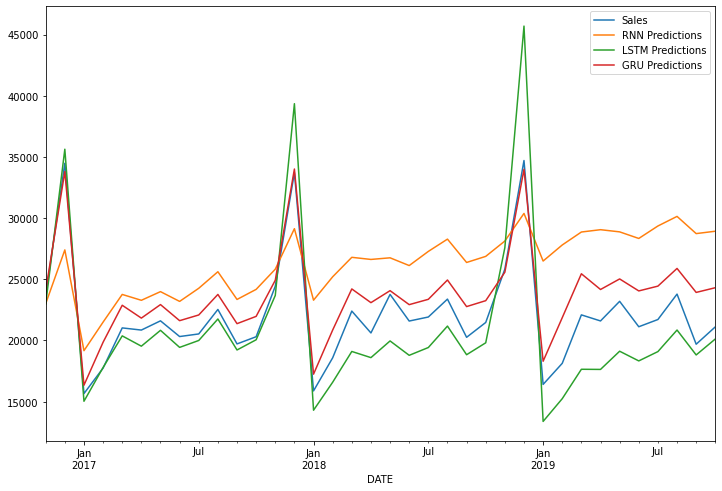

In [ ]:
true_predictions = scaler.inverse_transform(val_predictions)
val['GRU Predictions'] = true_predictions
val.plot(figsize=(12,8));

In [ ]:
print(f"MSE: {mean_squared_error(y_true=true_val, y_pred=true_predictions)}")
print(f"MAE: {mean_absolute_error(y_true=true_val, y_pred=true_predictions)}")
print(f"R2: {r2_score(y_true=true_val, y_pred=true_predictions)}")

MSE: 3981968.084541733
MAE: 1740.1009919593735
R2: 0.7857708854925135


#### Forecasting

In [ ]:
length = 12 #Ventana de tiempo de tamaño 12
batch_size = 1

In [ ]:
forecast = []

first_eval_batch = Xs_val[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(length):
    
    current_pred = model_gru.predict(current_batch)[0]    
    forecast.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)

In [ ]:
len(forecast)

12

In [ ]:
val.tail()

,Sales,RNN Predictions,LSTM Predictions,GRU Predictions
DATE,,,,
2019-06-01,21123,28338.425067,18331.196514,24050.863020
2019-07-01,21714,29356.738092,19092.204756,24442.505409
2019-08-01,23791,30140.551728,20854.503430,25887.911572
2019-09-01,19695,28735.171873,18818.439292,23928.339706
2019-10-01,21113,28928.950829,20122.925464,24312.510413


In [ ]:
forecast_index = pd.date_range(start='2019-11-01', periods=length, freq='MS')

In [ ]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index, columns=['Forecast'])

In [ ]:
forecast_df

,Forecast
2019-11-01,26451.961418
2019-12-01,34584.443028
2020-01-01,17072.982989
2020-02-01,19404.967145
2020-03-01,23490.988942
2020-04-01,22899.414909
2020-05-01,24319.267509
2020-06-01,22442.087193
2020-07-01,22994.591897
2020-08-01,25022.498098


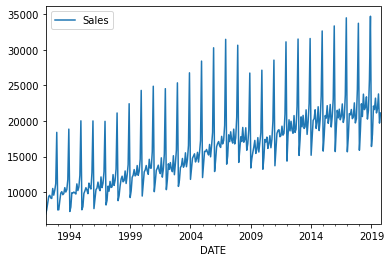

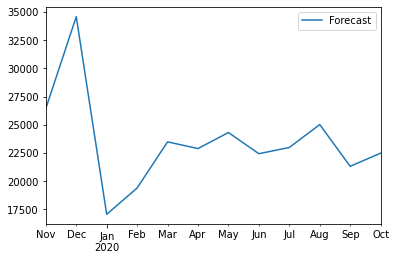

In [ ]:
df.plot()
forecast_df.plot();

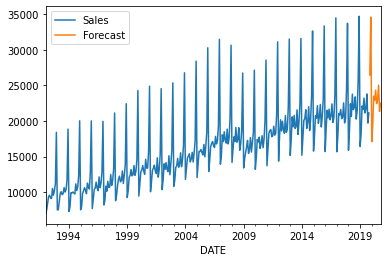

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax);

(573.0, 609.0)

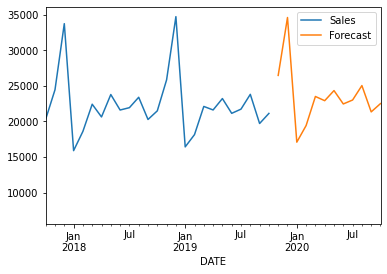

In [ ]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2017-10-01', '2020-10-01')